## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

In [5]:
df.user_id.duplicated().sum()

3894

d. The proportion of users converted.

In [6]:
(df.converted==1).mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [7]:
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].shape[0]

3893

f. Do any of the rows have missing values?

In [8]:
df.isnull().sum().any()

False

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [9]:
df2 = df.drop(df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].index)

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [11]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
df2[df2.user_id.duplicated(keep=False)]['user_id']

1899    773192
2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [13]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
df2.drop_duplicates(inplace = True)

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
(df2.converted==1).mean()

0.11959667567149027

b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
control_df= df2.query('group=="control"')
(control_df.converted==1).mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
treatment_df= df2.query('group=="treatment"')
(treatment_df.converted==1).mean()

0.11880724790277405

d. What is the probability that an individual received the new page?

In [18]:
(df2.landing_page == 'new_page').mean()

0.5000636646764286

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**We can see that the probability of conversion in each group and regardless of the group is almost the same. Hence, we can not decide whether the new page will lead to more conversion or not.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

 <li> $𝐻0 $ : $p_{new}$ - $p_{old}$  $<=0 $ </li> 

<li> $𝐻1 $ : $p_{new}$ - $p_{old}$  $>0 $ </li> 

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [19]:
new_rt = (df2.query('converted == 1')['user_id'].nunique())/df2.user_id.nunique()
new_rt

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [20]:
old_rt = (df2.query('converted == 1')['user_id'].nunique())/df2.user_id.nunique()
old_rt

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [21]:
new = treatment_df.user_id.nunique()
new 

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [22]:
old = control_df.user_id.nunique()
old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
new_page_converted = np.random.choice([0,1], size=new, p= [new_rt, 1-new_rt])
new_page_converted 

array([1, 1, 1, ..., 1, 1, 1])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
old_page_converted = np.random.choice([0,1], size=old, p= [old_rt, 1-old_rt])
    

old_page_converted 

array([0, 1, 1, ..., 0, 1, 1])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [25]:
new_page_converted.mean() - old_page_converted.mean()

0.00030509368618292232

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [26]:
p_diffs = []
for _ in range(10000):
    
    new_page_converted =np.random.choice([0,1], size=new, p= [new_rt, 1-new_rt]) 
    old_page_converted = np.random.choice([0,1], size=old, p= [old_rt, 1-old_rt])
    diff = new_page_converted.mean() - old_page_converted.mean()
    p_diffs.append(diff)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

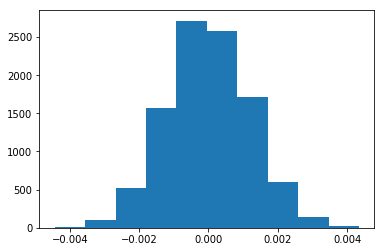

In [27]:
plt.hist(p_diffs);

**we can see in the above plot that the sampling distribution is normally distributed**

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [28]:
null_vals = np.random.normal(0, np.std(p_diffs), 10000)

In [29]:
#No. of converted users in both new page and old page
new_conv= treatment_df.query('converted==1')['user_id'].nunique()
old_conv= control_df.query('converted==1')['user_id'].nunique()
print(new_conv)
print(old_conv)

17264
17489


In [30]:
#Rate of conversion in both pages
new_rate = new_conv / new
old_rate = old_conv / old
print(new_rate)
print(old_rate)

0.11880806551510564
0.1203863045004612


In [31]:
#Compute the difference rate
diff_rate = new_rate - old_rate 
diff_rate

-0.0015782389853555567

In [32]:
#Calculate P-value

(null_vals > diff_rate).mean()

0.90620000000000001

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Assumed that the null is true, simulate from closest value under the null to the alternative. We calculated p-value to see which hypothesis we can approve. And since the p-value is 0.906 which is greater than 0.05 the value of alpha, we failed to reject the null hypothesis H0**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [33]:
import statsmodels.api as sm
convert_old = len(control_df.query('converted==1'))
convert_new =  len(treatment_df.query('converted==1'))
# calculated before in c. & d. as old, new
n_old = control_df.user_id.nunique
n_new = treatment_df.user_id.nunique

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [34]:

count = np.array([new_conv, old_conv])
nobs = np.array([new, old])
zstat, p_value = sm.stats.proportions_ztest(count,nobs, alternative='larger')
print(zstat)
print(p_value)

-1.31092419842
0.905058312759


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**The z-score indicates the difference between conversion in the two pages.The p-value here (0.9051) which is greater than alpha and similar to the p-value found in part II (0.9042). We conclude that z-test also failed to reject the null hypothesis.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**It's a logistic regression, because we want to predict one of two possible outcomes 0 or 1**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [35]:
df2['intercept'] = 1
df2[['ab_page', 'ab_page1']] = pd.get_dummies(df['landing_page'])

In [36]:
#Now drop col ab_page1 and keepl the col 'ab_page' where 1 represent "treatment" value
df2 = df2.drop('ab_page1', axis=1)

c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [37]:
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_mod.fit()


Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

**results.summary() generate an error, so I used summary 2. Reference: https://stackoverflow.com/questions/49814258/statsmodel-attributeerror-module-scipy-stats-has-no-attribute-chisqprob **

In [38]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-08-05 16:03 AIC:              212780.6032
No. Observations:   290585           BIC:              212801.7625
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290583           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3116  0.1897  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**p-value of ab_page is 0.1897, which indicates that the ab_page variable is not that significant to the dependent variable (converted) which is agree to the findings in the part II, where the null hypothesis failed to be rejected.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**By adding other factors, we can find factor that are more significant to the response variable. on the other hands, adding more factors can increase the chance of having correlated explanatory variables in our model and make the model more complex.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [39]:
#Read the countries file and print first few lines
df_country1 = pd.read_csv('countries.csv')
df_country1.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [40]:
#merge our df with countries df
df3 = df2.set_index('user_id').join(df_country1.set_index('user_id'))

In [41]:
df3.head()

,timestamp,group,landing_page,converted,intercept,ab_page,country
user_id,,,,,,,
630000,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1,US
630001,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1,US
630002,2017-01-19 19:20:56.438330,control,old_page,0,1,0,US
630003,2017-01-12 10:09:31.510471,treatment,new_page,0,1,1,US
630004,2017-01-18 20:23:58.824994,treatment,new_page,0,1,1,US


In [42]:
#check the values in country 
df3.country.value_counts()

US    203620
UK     72466
CA     14499
Name: country, dtype: int64

In [43]:
#create dummy variables
df3[['US', 'UK', 'CA']] = pd.get_dummies(df3['country'])

In [44]:
df3.head()

,timestamp,group,landing_page,converted,intercept,ab_page,country,US,UK,CA
user_id,,,,,,,,,,
630000,2017-01-19 06:26:06.548941,treatment,new_page,0,1,1,US,0,0,1
630001,2017-01-16 03:16:42.560309,treatment,new_page,1,1,1,US,0,0,1
630002,2017-01-19 19:20:56.438330,control,old_page,0,1,0,US,0,0,1
630003,2017-01-12 10:09:31.510471,treatment,new_page,0,1,1,US,0,0,1
630004,2017-01-18 20:23:58.824994,treatment,new_page,0,1,1,US,0,0,1


In [45]:
#generate and fit our model
log_mod2 = sm.Logit(df3['converted'], df3[['intercept','ab_page','UK', 'CA']])
results2 = log_mod2.fit()

Optimization terminated successfully.
         Current function value: 0.366112
         Iterations 6


In [46]:
#print result summary
results2.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-08-05 16:03 AIC:              212781.3782
No. Observations:   290585           BIC:              212823.6968
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0300    0.0266  -76.2486  0.0000  -2.0822  -1.9778
ab_page       -0.0150    0.0114   -1.3076  0.1910  -0.0374   0.0075
UK             0.0506    0.0284    1.7835  0.0745  -0.0050   0.1063
CA             0.0408    0.0269    1.5159  0.1296  -0.0119   0.0934
==================================================================

"""

**By looking to p-value (> 0.05) associated with each independent variable, we can tell that the country is also insignificant in predicting converted variable**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [47]:
#create interaction between variables
df3['page_UK']= df3['ab_page'] * df3['UK']
df3['page_CA']= df3['ab_page'] * df3['CA']

In [48]:
#generate and fit our model with interaction variables
log_mod3 = sm.Logit(df3['converted'], df3[['intercept','ab_page','UK', 'CA', 'page_UK', 'page_CA']])
results3 = log_mod3.fit()

Optimization terminated successfully.
         Current function value: 0.366108
         Iterations 6


In [49]:
#print result summary
results3.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2021-08-05 16:03 AIC:              212782.9124
No. Observations:   290585           BIC:              212846.3903
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290579           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0040    0.0364  -55.0077  0.0000  -2.0754  -1.9326
ab_page       -0.0674    0.0520   -1.2967  0.1947  -0.1694   0.0345
UK             0.0118    0.0398    0.2957  0.7674  -0.0663   0.0899
CA             0.0175    0.0377    0.4652  0.6418  -0.0563   0.0914
page_UK        0.0783    0.0568    1.3783  0.1681  -0.0330   0.1896
page_CA        0.0469    0.0538    0.8716  0.3834  -0.0585   0.1523
==================================================================

"""

In [50]:
#Exponentiate each Coef
np.exp(results3.params)

intercept    0.134794
ab_page      0.934776
UK           1.011854
CA           1.017682
page_UK      1.081428
page_CA      1.047989
dtype: float64

In [51]:
#multiplicative change of coef
1/ np.exp(results3.params)

intercept    7.418713
ab_page      1.069775
UK           0.988285
CA           0.982625
page_UK      0.924703
page_CA      0.954208
dtype: float64

**Again, from the p-value we can infer that neither page or country are significant to the conversion.**
Let's interepret the Coef. from multiplicative change: 
<li> ab_page: User with new page is convert 1.069 times as likely with old page, holding all other variables constant. </li>
<li>UK: User in UK is convert 0.988 times than people in US, holding all other variables constant.</li>
<li>CA: User in CA is convert 0.982 times than people in US, holding all other variables constant.</li>
<li>page_UK: User in UK and received the new page is 0.924 times likely to convert than people in US, holding all other variables constant.</li>
<li>page_CA: User in CA and received the new page is 0.954 times likely to convert than people in US, holding all other variables constant.</li>
So, based on the final result we can say the the new page has no impact on conversion. hence, we should keep the old page.

In [53]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0